<a href="https://colab.research.google.com/github/jxie5189/Pet_Expression-Specie_CNN/blob/main/Pets_expression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = "/content/drive/MyDrive/Colab Notebooks/Pets_expression"

class_folder_names = os.listdir(base_dir)

In [ ]:
class_folder_names

['.DS_Store', 'Sad', 'Angry', 'Master Folder', 'happy', 'Other']

In [ ]:
class_folder_names.remove('.DS_Store')
class_folder_names.remove('Master Folder')

In [ ]:
class_folder_names

['Sad', 'Angry', 'happy', 'Other']

#DataProcessing

In [ ]:
base_dir = "/content/drive/MyDrive/Colab Notebooks/Pets_expression"

#class_folder_names = os.listdir(base_dir)
print(class_folder_names)

print()

data = []

#for each different condition, for each files in the condition folder, if it's a picture('jpg'),
#add the direct path into the images
for folder in class_folder_names:
  for fileName in os.listdir(base_dir+'/'+folder):
    data.append({'path':os.path.join(base_dir, folder, fileName), 'label':folder})

print(data[0])

data_df = pd.DataFrame(data)

data_df.head()

['Sad', 'Angry', 'happy', 'Other']

{'path': '/content/drive/MyDrive/Colab Notebooks/Pets_expression/Sad/aug-91-008.jpg', 'label': 'Sad'}


,path,label
0,/content/drive/MyDrive/Colab Notebooks/Pets_ex...,Sad
1,/content/drive/MyDrive/Colab Notebooks/Pets_ex...,Sad
2,/content/drive/MyDrive/Colab Notebooks/Pets_ex...,Sad
3,/content/drive/MyDrive/Colab Notebooks/Pets_ex...,Sad
4,/content/drive/MyDrive/Colab Notebooks/Pets_ex...,Sad


#Replace labels with numerical values

In [ ]:
label_map = {'Sad':0, 'Angry':1, 'happy':2, 'Other':3}

data_df['label_num'] = data_df['label'].replace(label_map)

data_df.head()

,path,label,label_num
0,/content/drive/MyDrive/Colab Notebooks/Pets_ex...,Sad,0
1,/content/drive/MyDrive/Colab Notebooks/Pets_ex...,Sad,0
2,/content/drive/MyDrive/Colab Notebooks/Pets_ex...,Sad,0
3,/content/drive/MyDrive/Colab Notebooks/Pets_ex...,Sad,0
4,/content/drive/MyDrive/Colab Notebooks/Pets_ex...,Sad,0


In [ ]:
len(data_df)

1000

In [ ]:
len(data_df[data_df['label']=='happy'])

250

#Process images into Arrays

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image as PILImage
from PIL import ImageOps

def processImage(path):
  i = PILImage.open(path)
  #i = i.resize((1000, 500))
  i = ImageOps.pad(i, (250, 250), method=0, color=None)
  img_array = img_to_array(i)/255.0 #normlization
  return img_array

In [ ]:
data_df['image_array'] = data_df['path'].apply(processImage)

data_df.head()

,path,label,label_num,image_array
0,/content/drive/MyDrive/Colab Notebooks/Pets_ex...,Sad,0,"[[[0.8745098, 0.8235294, 0.7607843], [0.866666..."
1,/content/drive/MyDrive/Colab Notebooks/Pets_ex...,Sad,0,"[[[0.003921569, 0.003921569, 0.003921569], [0...."
2,/content/drive/MyDrive/Colab Notebooks/Pets_ex...,Sad,0,"[[[0.35686275, 0.42352942, 0.20784314], [0.349..."
3,/content/drive/MyDrive/Colab Notebooks/Pets_ex...,Sad,0,"[[[0.32156864, 0.3137255, 0.31764707], [0.3254..."
4,/content/drive/MyDrive/Colab Notebooks/Pets_ex...,Sad,0,"[[[0.5568628, 0.5411765, 0.5294118], [0.572549..."


#Split training and testing

In [ ]:
x = np.array(data_df['image_array'].tolist())
y = data_df['label_num']

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                            test_size=0.2,
                                            random_state=45)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(800, 250, 250, 3)
(800,)
(200, 250, 250, 3)
(200,)


#Built and train model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical


model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128,(3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(4, activation='softmax')
])

model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00025),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


#Data Augmentation

In [ ]:
#train/test using indices (conserve RAM)
from sklearn.model_selection import train_test_split

train_indices, test_indices = train_test_split(data_df.index, test_size=0.2, random_state=45)

train_df = data_df.loc[train_indices].reset_index(drop=True)
test_df = data_df.loc[test_indices].reset_index(drop=True)

In [ ]:
#make generator for artifical images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,           # Rescale pixel values to the range [0, 1]
    rotation_range=20,        # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,    # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,   # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,          # Shear intensity
    zoom_range=0.2,           # Randomly zoom into images
    horizontal_flip=True,     # Randomly flip images horizontally
    fill_mode='nearest'       # Fill in newly created pixels after rotation or shifting
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(250, 250),
    batch_size=32,
    class_mode='categorical'  # Use 'categorical' for multi-class classification
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=(250, 250),
    batch_size=32,
    class_mode='categorical'
)

Found 800 validated image filenames belonging to 4 classes.
Found 200 validated image filenames belonging to 4 classes.


#Training using articial images

In [ ]:
from tensorflow.keras.models import load_model

model_cnn = load_model('/content/drive/MyDrive/Colab Notebooks/cnn_0005_gen')

In [ ]:
model_cnn.fit(train_generator, epochs=5, validation_data=test_generator)
#Epoch 40/40
#25/25 [==============================] - 131s 5s/step - loss: 1.2473 - accuracy: 0.4162 - val_loss: 1.2412 - val_accuracy: 0.4550
#Epoch 40/40
#25/25 [==============================] - 133s 5s/step - loss: 1.0132 - accuracy: 0.5875 - val_loss: 1.0805 - val_accuracy: 0.6350
#Epoch 40/40
#25/25 [==============================] - 131s 5s/step - loss: 0.7558 - accuracy: 0.6950 - val_loss: 0.8528 - val_accuracy: 0.6800
#Epoch 40/40
#25/25 [==============================] - 146s 6s/step - loss: 0.5925 - accuracy: 0.8000 - val_loss: 0.7207 - val_accuracy: 0.7350
#Epoch 40/40
#25/25 [==============================] - 131s 5s/step - loss: 0.4695 - accuracy: 0.8338 - val_loss: 0.6338 - val_accuracy: 0.8150
#Epoch 40/40
#25/25 [==============================] - 127s 5s/step - loss: 0.3886 - accuracy: 0.8525 - val_loss: 0.7531 - val_accuracy: 0.7800
#Epoch 40/40
#25/25 [==============================] - 131s 5s/step - loss: 0.2749 - accuracy: 0.9038 - val_loss: 0.5990 - val_accuracy: 0.8400
#Epoch 40/40
#25/25 [==============================] - 122s 5s/step - loss: 0.2623 - accuracy: 0.9062 - val_loss: 0.6502 - val_accuracy: 0.8100
##change LR to 0.00025
#Epoch 20/20
#25/25 [==============================] - 122s 5s/step - loss: 0.2501 - accuracy: 0.9150 - val_loss: 0.5994 - val_accuracy: 0.8450
#Epoch 20/20
#25/25 [==============================] - 121s 5s/step - loss: 0.2602 - accuracy: 0.9162 - val_loss: 0.7575 - val_accuracy: 0.8050
#Epoch 20/20
#25/25 [==============================] - 123s 5s/step - loss: 0.2949 - accuracy: 0.9100 - val_loss: 0.7823 - val_accuracy: 0.7800

Epoch 1/5
25/25 [==============================] - 136s 5s/step - loss: 0.2841 - accuracy: 0.9087 - val_loss: 1.0835 - val_accuracy: 0.7950
Epoch 2/5
25/25 [==============================] - 136s 5s/step - loss: 0.2578 - accuracy: 0.9050 - val_loss: 0.8904 - val_accuracy: 0.8200
Epoch 3/5
25/25 [==============================] - 144s 6s/step - loss: 0.1889 - accuracy: 0.9325 - val_loss: 0.7628 - val_accuracy: 0.8300
Epoch 4/5
25/25 [==============================] - 133s 5s/step - loss: 0.2047 - accuracy: 0.9250 - val_loss: 0.6410 - val_accuracy: 0.8500
Epoch 5/5
25/25 [==============================] - 132s 5s/step - loss: 0.2094 - accuracy: 0.9312 - val_loss: 0.8381 - val_accuracy: 0.8150


In [ ]:
model_cnn.save('/content/drive/MyDrive/Colab Notebooks/cnn_0005_gen')

In [ ]:
model_cnn_lr0005_gen = load_model('/content/drive/MyDrive/Colab Notebooks/cnn_0005_gen')

#Training the bare model (only organic images)

In [ ]:
y_train_one_hot = to_categorical(y_train, num_classes=4)
y_test_one_hot = to_categorical(y_test, num_classes=4)

#default Adam learning rate with only 800 train samples / 200 test samples
model_cnn.fit(x_train, y_train_one_hot, epochs=20, validation_data=(x_test, y_test_one_hot))

#save model arch/weight

In [ ]:
model_cnn.save('/content/drive/MyDrive/Colab Notebooks/species_mood_CNN_model_orig')

In [ ]:
from tensorflow.keras.models import load_model

model_cnn = load_model('/content/drive/MyDrive/Colab Notebooks/species_mood_CNN_model_orig')

#Evaluate test set

In [ ]:
model_cnn.evaluate(x_test, y_test_one_hot, verbose=2)

7/7 - 12s - loss: 12.1856 - accuracy: 0.0700 - 12s/epoch - 2s/step


[12.185647964477539, 0.07000000029802322]

In [ ]:
model_cnn_lr0005_gen.evaluate(x_test, y_test_one_hot, verbose=2)

NameError: ignored

#Convert back to label from model output


In [ ]:
def model_translate(model_output, labelmap):

  labels = [labels for labels in labelmap]

  normalized_probabilities = np.exp(model_output) / np.sum(np.exp(model_output), axis=1, keepdims=True)

  finalOutput_df = pd.DataFrame({'Condition':labels, 'Percentage':normalized_probabilities[0]})

  highest_precentage = round(finalOutput_df['Percentage'].max()*100, 2)

  highest_percentage_idx = finalOutput_df['Percentage'].idxmax()

  predicted_class = finalOutput_df['Condition'].iloc[highest_percentage_idx]

  print(f'The predicted class for the image is {predicted_class} with {highest_precentage}% confidence')
  print()
  print('Total Predication and Percentage')
  #print(finalOutput_df)
  return finalOutput_df

#display method

In [ ]:
from IPython.display import display as IpyDisplay, Image as IpyImage

def displayPet(path):
  image_path = path
  return IpyDisplay(IpyImage(filename=image_path))

#model result helper

In [ ]:
  def modelResult( model_output, labelmap):
    labels = [labels for labels in labelmap]
    normalized_probabilities = np.exp(model_output) / np.sum(np.exp(model_output), axis=1, keepdims=True)
    finalOutput_df = pd.DataFrame({'Condition':labels, 'Percentage':normalized_probabilities[0]})
    highest_precentage = round(finalOutput_df['Percentage'].max()*100, 2)
    highest_percentage_idx = finalOutput_df['Percentage'].idxmax()
    predicted_class = finalOutput_df['Condition'].iloc[highest_percentage_idx]
    return predicted_class

#Make Application

In [ ]:
class PetDeciper:
  def loadMoodModel(self,model):
    self.moodModel = model

  def loadSpecieModel(self, model):
    self.specieModel = model

  def evaluateMood(self, image_path):
    ready_image = self.__convert_image__(image_path)
    result = self.moodModel(ready_image)
    self.displayImage(image_path)
    label_map = {'Sad':0, 'Angry':1, 'happy':2, 'Other':3}
    return model_translate(result, label_map)

  def evaluateSpecie(self, image_path):
    ready_image = self.__convert_image__(image_path)
    result = self.specieModel(ready_image)
    self.displayImage(image_path)
    label_map = {'dog':0, 'cat':1, 'other':2}
    return model_translate(result, label_map)

  def happyDog(self, image_path):

    specie_map = {'dog':0, 'cat':1, 'other':2}
    mood_map = {'Sad':0, 'Angry':1, 'happy':2, 'Other':3}

    ready_image = self.__convert_image__(image_path)

    mood_result = self.moodModel(ready_image)
    specie_result = self.specieModel(ready_image)

    mood = modelResult(mood_result, mood_map)
    specie = modelResult(specie_result, specie_map)

    self.displayImage(image_path)

    if mood=='happy' and specie=='dog':
      return 'This is a happy dog'
    else:
      return 'This is not a happy dog'

  def __model_output__(self, result, label_map):
    labels = [labels for labels in label_map]
    normalized_probabilities = np.exp(result) / np.sum(np.exp(result), axis=1, keepdims=True)
    finalOutput_df = pd.DataFrame({'Condition':labels, 'Percentage':normalized_probabilities[0]})
    highest_percentage_idx = finalOutput_df['Percentage'].idxmax()
    predicted_class = finalOutput_df['Condition'].iloc[highest_percentage_idx]
    return predicted_class

  def __convert_image__(self, image_path):
    image = processImage(image_path)
    image_array = np.asarray(image)
    ready_image = np.expand_dims(image_array, axis = 0)
    return ready_image

  def displayImage(self, image_path):
    path = image_path
    return IpyDisplay(IpyImage(filename=image_path))

#Instant Application

In [ ]:
#make application
petDeciper = PetDeciper()
petDeciper.loadMoodModel(model_cnn)
#petDeciper.loadMoodModel(model_cnn_lr0005_gen)

#Load speices CNN model

In [ ]:
#load 2nd CNN model
from tensorflow.keras.models import load_model
species_model = load_model('/content/drive/MyDrive/Colab Notebooks/species_CNN_model')

#Load into the application

In [ ]:
#load CNN into the application
petDeciper.loadSpecieModel(species_model)

In [ ]:
test1 = data_df.sample(1)
test1 = test1['path'].iloc[0]
test1

'/content/drive/MyDrive/Colab Notebooks/Pets_expression/Sad/aug-22-031.jpg'

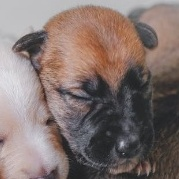

'This is not a happy dog'

In [ ]:
petDeciper.happyDog(test1)

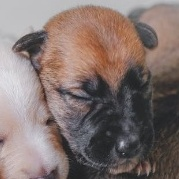

The predicted class for the image is happy with 47.51% confidence

Total Predication and Percentage


,Condition,Percentage
0,Sad,0.174942
1,Angry,0.175004
2,happy,0.475110
3,Other,0.174944


In [ ]:
petDeciper.evaluateMood(test1)

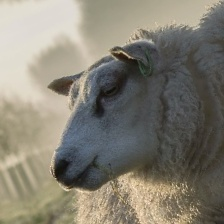

The predicted class for the image is other with 38.73% confidence

Total Predication and Percentage


,Condition,Percentage
0,dog,0.311446
1,cat,0.301225
2,other,0.387329


In [ ]:
petDeciper.evaluateSpecie(test1)

#Sample Testing

In [ ]:
random_samples = test_df.sample(3)
sample_1 = random_samples.iloc[0]
sample_2 = random_samples.iloc[1]
sample_3 = random_samples.iloc[2]


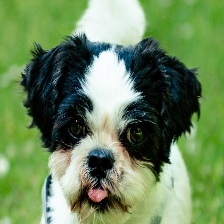

The predicted class for the image is Other with 45.65% confidence

Total Predication and Percentage


,Condition,Percentage
0,Sad,0.186948
1,Angry,0.178826
2,happy,0.177741
3,Other,0.456485


In [ ]:
petDeciper.evaluateMood(sample_1['path'])

In [ ]:
print('Sample 1 is actually '+sample_1['label'])

Sample 1 is actually happy


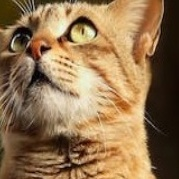

The predicted class for the image is other with 38.73% confidence

Total Predication and Percentage


,Condition,Percentage
0,dog,0.311446
1,cat,0.301225
2,other,0.387329


In [ ]:
petDeciper.evaluateSpecie(sample_2['path'])

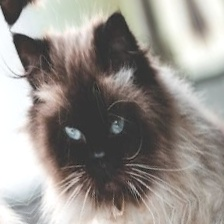

'This is not a happy dog'

In [ ]:
petDeciper.happyDog(sample_3['path'])

In [ ]:
print('Sample 3 is actually '+sample_3['label'])

Sample 3 is actually Sad
